In [145]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import shutil
import cv2
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau


import torchmetrics.functional as metrics
from torchinfo import summary
from torchmetrics.functional.classification import multiclass_accuracy

In [112]:
artistDF = pd.read_csv('train.csv',index_col=0)
print(artistDF['artist'].unique())

['Diego Velazquez' 'Vincent van Gogh' 'Claude Monet' 'Edgar Degas'
 'Hieronymus Bosch' 'Pierre-Auguste Renoir' 'Rene Magritte' 'Michelangelo'
 'Peter Paul Rubens' 'Caravaggio' 'Alfred Sisley' 'Edouard Manet'
 'Rembrandt' 'Francisco Goya' 'Pablo Picasso' 'Titian' 'Mikhail Vrubel'
 'Leonardo da Vinci' 'Kazimir Malevich' 'Andy Warhol' 'Vasiliy Kandinskiy'
 'Gustav Klimt' 'Amedeo Modigliani' 'Henri Rousseau' 'Salvador Dali'
 'Pieter Bruegel' 'Albrecht Du rer' 'Paul Gauguin' 'Sandro Botticelli'
 'Piet Mondrian' 'Eugene Delacroix' 'Paul Klee' 'William Turner'
 'Marc Chagall' 'Jan van Eyck' 'Henri Matisse' 'El Greco'
 'Gustave Courbet' 'Andrei Rublev' 'Jackson Pollock' 'Edvard Munch'
 'Camille Pissarro' 'Raphael' 'Henri de Toulouse-Lautrec' 'Joan Miro'
 'Giotto di Bondone' 'Diego Rivera' 'Frida Kahlo' 'Georges Seurat'
 'Paul Cezanne']


In [113]:
artistDF.value_counts('artist')

artist
Vincent van Gogh             629
Edgar Degas                  490
Pablo Picasso                303
Pierre-Auguste Renoir        233
Paul Gauguin                 220
Albrecht Du rer              220
Francisco Goya               204
Rembrandt                    181
Marc Chagall                 173
Titian                       173
Alfred Sisley                164
Paul Klee                    142
Rene Magritte                137
Andy Warhol                  132
Amedeo Modigliani            132
Henri Matisse                121
Sandro Botticelli            120
Mikhail Vrubel               118
Hieronymus Bosch             115
Leonardo da Vinci            101
Salvador Dali                 99
Peter Paul Rubens             97
Kazimir Malevich              91
Pieter Bruegel                85
Frida Kahlo                   84
Diego Velazquez               81
Joan Miro                     76
Andrei Rublev                 74
Raphael                       73
Giotto di Bondone             72
Gus

In [114]:
styleDF = pd.read_csv('../data/style_train.csv',header=None)
styleDF.columns = ['pathway','style_code']
styleDF

,pathway,style_code
0,Impressionism/edgar-degas_landscape-on-the-orn...,12
1,Realism/camille-corot_mantes-cathedral.jpg,21
2,Abstract_Expressionism/gene-davis_untitled-197...,0
3,Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg,24
4,Impressionism/maurice-prendergast_paris-boulev...,12
...,...,...
57020,Romanticism/pavel-svinyin_new-york-city-and-ha...,23
57021,Cubism/franz-marc_sleeping-animals-1913.jpg,7
57022,Romanticism/dante-gabriel-rossetti_helen-of-tr...,23
57023,Romanticism/arnold-bã¶cklin_portrait-of-actres...,23


In [115]:
outlist=styleDF.value_counts('style_code')[styleDF.value_counts('style_code')<600].index
outlist

Index([18, 6, 16, 25, 2, 1], dtype='int64', name='style_code')

In [116]:
styleTrueDF = styleDF[styleDF['style_code'] != (a for a in outlist)]
styleTrueDF.value_counts('style_code')

style_code
12    9142
21    7514
23    4914
9     4716
20    4516
24    3170
3     3034
4     2969
0     1948
17    1787
15    1684
7     1565
22    1463
5     1131
19    1039
8      974
11     941
14     936
13     896
26     817
10     654
18     360
6      337
16     220
25     152
2       77
1       69
Name: count, dtype: int64

In [117]:
pile_path = '../data/wikiart_64/wikiart/'
new_path = '../data/style/'
name_path_List = styleTrueDF['pathway'].tolist()


In [118]:
styletxtDF = pd.read_csv('../data/style_class.txt',sep=' ',header=None)
styletxtDF.columns=['style_code','style']
styletxtDF

,style_code,style
0,0,Abstract_Expressionism
1,1,Action_painting
2,2,Analytical_Cubism
3,3,Art_Nouveau
4,4,Baroque
5,5,Color_Field_Painting
6,6,Contemporary_Realism
7,7,Cubism
8,8,Early_Renaissance
9,9,Expressionism


In [119]:
styleTrainDF = pd.merge(styleTrueDF,styletxtDF ,on='style_code')
styleTrainDF.value_counts('style_code')

style_code
12    9142
21    7514
23    4914
9     4716
20    4516
24    3170
3     3034
4     2969
0     1948
17    1787
15    1684
7     1565
22    1463
5     1131
19    1039
8      974
11     941
14     936
13     896
26     817
10     654
18     360
6      337
16     220
25     152
2       77
1       69
Name: count, dtype: int64

In [120]:
styleTrainDF

,pathway,style_code,style
0,Impressionism/edgar-degas_landscape-on-the-orn...,12,Impressionism
1,Impressionism/maurice-prendergast_paris-boulev...,12,Impressionism
2,Impressionism/claude-monet_morning-on-the-sein...,12,Impressionism
3,Impressionism/edgar-degas_dancers-backstage-de...,12,Impressionism
4,Impressionism/claude-monet_the-tea-set.jpg,12,Impressionism
...,...,...,...
57020,Analytical_Cubism/georges-braque_houses-at-est...,2,Analytical_Cubism
57021,Analytical_Cubism/albert-gleizes_woman-with-an...,2,Analytical_Cubism
57022,Analytical_Cubism/juan-gris_man-in-the-cafe-19...,2,Analytical_Cubism
57023,Analytical_Cubism/pablo-picasso_bathers-drying...,2,Analytical_Cubism


In [121]:
imgtest=cv2.imread(pile_path+name_path_List[0])
print(imgtest.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
# # 데이터프레임에 해당되는 그림 만 복사
# 
# pile_path = '../data/wikiart_64/wikiart/'
# new_path = '../data/style/'
# def copy_image_via_category(ROOT, TARGET, df, find='style'):
#     os.makedirs(TARGET, exist_ok=True)
#     for i, row in enumerate(df['pathway'].values):
#     # Image.open(ROOT + df_total_weight.iloc[0]['filelocation'], 'r')
#         os.makedirs(TARGET + df.iloc[i][find], exist_ok=True)
#         shutil.copy(ROOT + row[:-4]+'_resized_resized_resized.jpg', TARGET + df.iloc[i][find] + '/')
# 
# #copy_image_via_category(ROOT, TARGET, df_total_weight)
# copy_image_via_category(pile_path, new_path, styleTrueDF,'style')

### 깨진 그림 복원

In [ ]:
# pile_name1 = '../data/wikiart_64/wikiart/Baroque/rembrandt_woman-standing-with-raised-hands_resized_resized_resized.jpg'
# imgNP1 = cv2.imread(pile_name1)
# imgNP2 = cv2.resize(imgNP1,(64,64))
# cv2.imwrite(pile_name1,imgNP2)

In [ ]:
# pile_name2 = '../data/wikiart_64/wikiart/Post_Impressionism/vincent-van-gogh_l-arlesienne-portrait-of-madame-ginoux-1890_resized_resized_resized.jpg'
# imgNP3 = cv2.imread(pile_name2)
# imgNP4 = cv2.resize(imgNP3,(64,64))
# cv2.imwrite(pile_name2,imgNP4)

In [123]:
# train, val 데이터 csv 확인
trainDF = pd.read_csv('../data/style_train.csv',header=None)
trainDF.columns = ['pathway','style_code']
valDF = pd.read_csv('../data/style_val.csv', header=None)
valDF.columns =  ['pathway','style_code']
styletxtDF = pd.read_csv('../data/style_class.txt',sep=' ',header=None)
styletxtDF.columns=['style_code','style']
styletxtDF


In [ ]:
# 파일 복사 함수 생성
def copy_image_via_category(ROOT, TARGET, df, find='style'):
    os.makedirs(TARGET, exist_ok=True)
    for i, row in enumerate(df['pathway'].values):
    # Image.open(ROOT + df_total_weight.iloc[0]['filelocation'], 'r')
        os.makedirs(TARGET + df.iloc[i][find], exist_ok=True)
        shutil.copy(ROOT + row[:-4]+'_resized_resized_resized.jpg', TARGET + df.iloc[i][find] + '/')



In [138]:
trainDF.value_counts('style_code')

style_code
12    9142
21    7514
23    4914
9     4716
20    4516
24    3170
3     3034
4     2969
0     1948
17    1787
15    1684
7     1565
22    1463
5     1131
19    1039
8      974
11     941
14     936
13     896
26     817
10     654
18     360
6      337
16     220
25     152
2       77
1       69
Name: count, dtype: int64

In [125]:
valDF

,pathway,style_code
0,Impressionism/edgar-degas_dancers-on-set-1880.jpg,12
1,Impressionism/claude-monet_water-lilies-6.jpg,12
2,Impressionism/giovanni-boldini_a-guitar-player...,12
3,Impressionism/john-singer-sargent_at-torre-gal...,12
4,Impressionism/john-singer-sargent_artist-in-th...,12
...,...,...
24416,Naive_Art_Primitivism/niko-pirosmani_leaning-a...,15
24417,Naive_Art_Primitivism/marc-chagall_russian-wed...,15
24418,Naive_Art_Primitivism/camille-bombois_port-de-...,15
24419,Naive_Art_Primitivism/marc-chagall_god-directs...,15


In [127]:
styletxtDF

,style_code,style
0,0,Abstract_Expressionism
1,1,Action_painting
2,2,Analytical_Cubism
3,3,Art_Nouveau
4,4,Baroque
5,5,Color_Field_Painting
6,6,Contemporary_Realism
7,7,Cubism
8,8,Early_Renaissance
9,9,Expressionism


In [128]:
trainDF = pd.merge(trainDF,styletxtDF,on = 'style_code')
trainDF

,pathway,style_code,style
0,Impressionism/edgar-degas_landscape-on-the-orn...,12,Impressionism
1,Impressionism/maurice-prendergast_paris-boulev...,12,Impressionism
2,Impressionism/claude-monet_morning-on-the-sein...,12,Impressionism
3,Impressionism/edgar-degas_dancers-backstage-de...,12,Impressionism
4,Impressionism/claude-monet_the-tea-set.jpg,12,Impressionism
...,...,...,...
57020,Analytical_Cubism/georges-braque_houses-at-est...,2,Analytical_Cubism
57021,Analytical_Cubism/albert-gleizes_woman-with-an...,2,Analytical_Cubism
57022,Analytical_Cubism/juan-gris_man-in-the-cafe-19...,2,Analytical_Cubism
57023,Analytical_Cubism/pablo-picasso_bathers-drying...,2,Analytical_Cubism


In [129]:
valDF = pd.merge(valDF,styletxtDF, on = 'style_code')
valDF

,pathway,style_code,style
0,Impressionism/edgar-degas_dancers-on-set-1880.jpg,12,Impressionism
1,Impressionism/claude-monet_water-lilies-6.jpg,12,Impressionism
2,Impressionism/giovanni-boldini_a-guitar-player...,12,Impressionism
3,Impressionism/john-singer-sargent_at-torre-gal...,12,Impressionism
4,Impressionism/john-singer-sargent_artist-in-th...,12,Impressionism
...,...,...,...
24416,Naive_Art_Primitivism/niko-pirosmani_leaning-a...,15,Naive_Art_Primitivism
24417,Naive_Art_Primitivism/marc-chagall_russian-wed...,15,Naive_Art_Primitivism
24418,Naive_Art_Primitivism/camille-bombois_port-de-...,15,Naive_Art_Primitivism
24419,Naive_Art_Primitivism/marc-chagall_god-directs...,15,Naive_Art_Primitivism


In [130]:
pile_path = '../data/wikiart_64/wikiart/'
train_path = '../data/style_train/'
val_path = '../data/style_val/'

# train 만 꺼내서 복사
copy_image_via_category(pile_path, train_path, trainDF)
copy_image_via_category(pile_path, val_path, valDF)

In [131]:
# 데이터셋 설정(Resnet 전처리 겸)
preprocessing = transforms.Compose(transforms=[
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainDS = ImageFolder(train_path, transform=preprocessing)
valDS = ImageFolder(val_path, transform=preprocessing)


In [133]:
print(trainDS.classes, trainDS.targets, sep='\n')


['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism', 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance', 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism', 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [135]:
print(len(valDS.targets))
print(len(trainDS.targets))


24421
57025


In [170]:
# --> resnet18 모델 설계

### 사전학습된 모델 인스턴스 생성
res_model = resnet18(weights=ResNet18_Weights.DEFAULT)
res_model2 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

## 전 결합층 변경 (출력 클래스 수: 27개)
res_model.fc = nn.Linear(512, 27)
res_model2.fc = nn.Linear(512, 27)

In [161]:
summary(res_model,(1782, 3,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1782, 27]                --
├─Conv2d: 1-1                            [1782, 64, 32, 32]        9,408
├─BatchNorm2d: 1-2                       [1782, 64, 32, 32]        128
├─ReLU: 1-3                              [1782, 64, 32, 32]        --
├─MaxPool2d: 1-4                         [1782, 64, 16, 16]        --
├─Sequential: 1-5                        [1782, 64, 16, 16]        --
│    └─BasicBlock: 2-1                   [1782, 64, 16, 16]        --
│    │    └─Conv2d: 3-1                  [1782, 64, 16, 16]        36,864
│    │    └─BatchNorm2d: 3-2             [1782, 64, 16, 16]        128
│    │    └─ReLU: 3-3                    [1782, 64, 16, 16]        --
│    │    └─Conv2d: 3-4                  [1782, 64, 16, 16]        36,864
│    │    └─BatchNorm2d: 3-5             [1782, 64, 16, 16]        128
│    │    └─ReLU: 3-6                    [1782, 64, 16, 16]        --
│

In [143]:
### Resnet18 Feature Module 파라미터 requires_grad = True ==> False 비활성화
for name, param in res_model.named_parameters():
    print(name, param.requires_grad, end='  ===>     ')
    param.requires_grad = False
    print(param.requires_grad)

### Resnet18 Full Connected Module 파라미터 requires_grad = False ===> True 활성화
for name, param in res_model.fc.named_parameters():
    print(name, param.requires_grad, end='  ===>     ')
    param.requires_grad = True
    print(param.requires_grad)

conv1.weight True  ===>     False
bn1.weight True  ===>     False
bn1.bias True  ===>     False
layer1.0.conv1.weight True  ===>     False
layer1.0.bn1.weight True  ===>     False
layer1.0.bn1.bias True  ===>     False
layer1.0.conv2.weight True  ===>     False
layer1.0.bn2.weight True  ===>     False
layer1.0.bn2.bias True  ===>     False
layer1.1.conv1.weight True  ===>     False
layer1.1.bn1.weight True  ===>     False
layer1.1.bn1.bias True  ===>     False
layer1.1.conv2.weight True  ===>     False
layer1.1.bn2.weight True  ===>     False
layer1.1.bn2.bias True  ===>     False
layer2.0.conv1.weight True  ===>     False
layer2.0.bn1.weight True  ===>     False
layer2.0.bn1.bias True  ===>     False
layer2.0.conv2.weight True  ===>     False
layer2.0.bn2.weight True  ===>     False
layer2.0.bn2.bias True  ===>     False
layer2.0.downsample.0.weight True  ===>     False
layer2.0.downsample.1.weight True  ===>     False
layer2.0.downsample.1.bias True  ===>     False
layer2.1.conv1.wei

In [223]:
### Resnet18 Feature Module 파라미터 requires_grad = True ==> False 비활성화
for name, param in res_model2.named_parameters():
    print(name, param.requires_grad, end='  ===>     ')
    param.requires_grad = False
    print(param.requires_grad)

### Resnet18 Full Connected Module 파라미터 requires_grad = False ===> True 활성화
for name, param in res_model2.fc.named_parameters():
    print(name, param.requires_grad, end='  ===>     ')
    param.requires_grad = True
    print(param.requires_grad)

conv1.weight True  ===>     False
bn1.weight True  ===>     False
bn1.bias True  ===>     False
layer1.0.conv1.weight True  ===>     False
layer1.0.bn1.weight True  ===>     False
layer1.0.bn1.bias True  ===>     False
layer1.0.conv2.weight True  ===>     False
layer1.0.bn2.weight True  ===>     False
layer1.0.bn2.bias True  ===>     False
layer1.1.conv1.weight True  ===>     False
layer1.1.bn1.weight True  ===>     False
layer1.1.bn1.bias True  ===>     False
layer1.1.conv2.weight True  ===>     False
layer1.1.bn2.weight True  ===>     False
layer1.1.bn2.bias True  ===>     False
layer2.0.conv1.weight True  ===>     False
layer2.0.bn1.weight True  ===>     False
layer2.0.bn1.bias True  ===>     False
layer2.0.conv2.weight True  ===>     False
layer2.0.bn2.weight True  ===>     False
layer2.0.bn2.bias True  ===>     False
layer2.0.downsample.0.weight True  ===>     False
layer2.0.downsample.1.weight True  ===>     False
layer2.0.downsample.1.bias True  ===>     False
layer2.1.conv1.wei

In [164]:
### ===> 학습 준비
optimizer = optim.Adam(res_model.fc.parameters())
schedular = ReduceLROnPlateau(optimizer, 'min',factor=0.01, patience=10)
loss_fn = nn.CrossEntropyLoss() # 손실함수 정의
EPOCHS = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classes = 27
batch_size = 64

In [165]:
## 데이터 로더 생성
trainDL = DataLoader(trainDS, batch_size=batch_size, shuffle=True, drop_last=True)
valDL = DataLoader(valDS, batch_size=batch_size, shuffle=True, drop_last=True)



In [206]:
### ===>  데이터 확인하기 (1) 
for (X_train, y_train) in trainDL:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([64, 3, 64, 64]) type: torch.FloatTensor
y_train: torch.Size([64]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

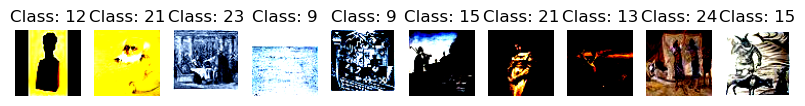

In [207]:
### ===>  데이터 확인하기 (2) 
import matplotlib.pyplot as plt
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

CNN 모델 확인

In [166]:
### ===> CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")

In [167]:
### ===> 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, val_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(device)
            label = label.to(device)
            
            output = model(image)
            test_loss += loss_fn(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(val_loader)
    test_accuracy = 100. * correct / len(val_loader.dataset)
    return test_loss, test_accuracy

In [168]:
### ===>  학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for epoch in range(1, EPOCHS + 1):
    
    train(epoch, res_model, trainDL, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(res_model, valDL)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")
    

Train Epoch: 1 [0]	Train Loss: 3.924757
Train Epoch: 1 [200]	Train Loss: 2.425752
Train Epoch: 1 [400]	Train Loss: 2.543280
Train Epoch: 1 [600]	Train Loss: 2.252789
Train Epoch: 1 [800]	Train Loss: 2.312379

[EPOCH: 1], 	Test Loss: 2.3189, 	Test Accuracy: 28.44 % 
Train Epoch: 2 [0]	Train Loss: 2.081721
Train Epoch: 2 [200]	Train Loss: 2.291845
Train Epoch: 2 [400]	Train Loss: 2.309896
Train Epoch: 2 [600]	Train Loss: 2.329530
Train Epoch: 2 [800]	Train Loss: 2.135122

[EPOCH: 2], 	Test Loss: 2.3081, 	Test Accuracy: 28.75 % 
Train Epoch: 3 [0]	Train Loss: 2.249246
Train Epoch: 3 [200]	Train Loss: 2.431376
Train Epoch: 3 [400]	Train Loss: 2.412642
Train Epoch: 3 [600]	Train Loss: 1.989261
Train Epoch: 3 [800]	Train Loss: 1.954425

[EPOCH: 3], 	Test Loss: 2.3168, 	Test Accuracy: 28.80 % 
Train Epoch: 4 [0]	Train Loss: 2.097560
Train Epoch: 4 [200]	Train Loss: 2.130308
Train Epoch: 4 [400]	Train Loss: 2.400193
Train Epoch: 4 [600]	Train Loss: 2.111569
Train Epoch: 4 [800]	Train Loss: 2.4

In [ ]:
res_model

In [169]:

import torchvision.datasets as datasets

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 64 channels * 8 * 8 after 3 pooling layers
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_cnn_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    # GPU를 사용할 수 있는 경우 GPU로 모델을 이동합니다.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 크로스 엔트로피 손실 함수를 정의합니다.
    criterion = nn.CrossEntropyLoss()
    
    # 옵티마이저를 정의합니다. 여기서는 Adam을 사용합니다.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 모델을 학습 모드로 설정합니다.
    model.train()
    
    # 주어진 에포크 수만큼 반복하여 모델을 학습합니다.
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        # 미니배치 단위로 데이터를 가져와서 학습을 진행합니다.
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 모델에 입력을 전달하여 출력을 계산합니다.
            outputs = model(inputs)
            
            # 손실을 계산합니다.
            loss = criterion(outputs, labels)
            
            # 역전파 단계를 수행하고 옵티마이저로 모델의 가중치를 업데이트합니다.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # 매 에포크마다 손실을 출력합니다.
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    print('Finished Training')


# 클래스 갯수가 27개인 CNN 모델을 생성합니다.
num_classes = 27
cnn_model = CNN(num_classes)

# 학습을 진행합니다.
train_cnn_model(cnn_model, trainDL)


Epoch [1/10], Loss: 2.4060
Epoch [2/10], Loss: 2.1096
Epoch [3/10], Loss: 1.9407
Epoch [4/10], Loss: 1.7527
Epoch [5/10], Loss: 1.5166
Epoch [6/10], Loss: 1.2308
Epoch [7/10], Loss: 0.9247
Epoch [8/10], Loss: 0.6631
Epoch [9/10], Loss: 0.4775
Epoch [10/10], Loss: 0.3706
Finished Training


In [171]:
### ===>  학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for epoch in range(1, EPOCHS + 1):
    
    test_loss, test_accuracy = evaluate(cnn_model, valDL)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")
    


[EPOCH: 1], 	Test Loss: 4.0259, 	Test Accuracy: 31.51 % 

[EPOCH: 2], 	Test Loss: 4.0259, 	Test Accuracy: 31.53 % 

[EPOCH: 3], 	Test Loss: 4.0252, 	Test Accuracy: 31.53 % 

[EPOCH: 4], 	Test Loss: 4.0257, 	Test Accuracy: 31.53 % 

[EPOCH: 5], 	Test Loss: 4.0257, 	Test Accuracy: 31.51 % 

[EPOCH: 6], 	Test Loss: 4.0241, 	Test Accuracy: 31.52 % 

[EPOCH: 7], 	Test Loss: 4.0262, 	Test Accuracy: 31.53 % 

[EPOCH: 8], 	Test Loss: 4.0218, 	Test Accuracy: 31.53 % 

[EPOCH: 9], 	Test Loss: 4.0234, 	Test Accuracy: 31.54 % 

[EPOCH: 10], 	Test Loss: 4.0259, 	Test Accuracy: 31.52 % 


In [172]:
### ===>  학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for epoch in range(1, EPOCHS + 1):
    
    train(epoch, res_model2, trainDL, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(res_model, valDL)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")
    

Train Epoch: 1 [0]	Train Loss: 3.519549
Train Epoch: 1 [200]	Train Loss: 3.493045
Train Epoch: 1 [400]	Train Loss: 3.583380
Train Epoch: 1 [600]	Train Loss: 3.625151
Train Epoch: 1 [800]	Train Loss: 3.626756

[EPOCH: 1], 	Test Loss: 4.3509, 	Test Accuracy: 1.67 % 
Train Epoch: 2 [0]	Train Loss: 3.610140
Train Epoch: 2 [200]	Train Loss: 3.650734


KeyboardInterrupt: 

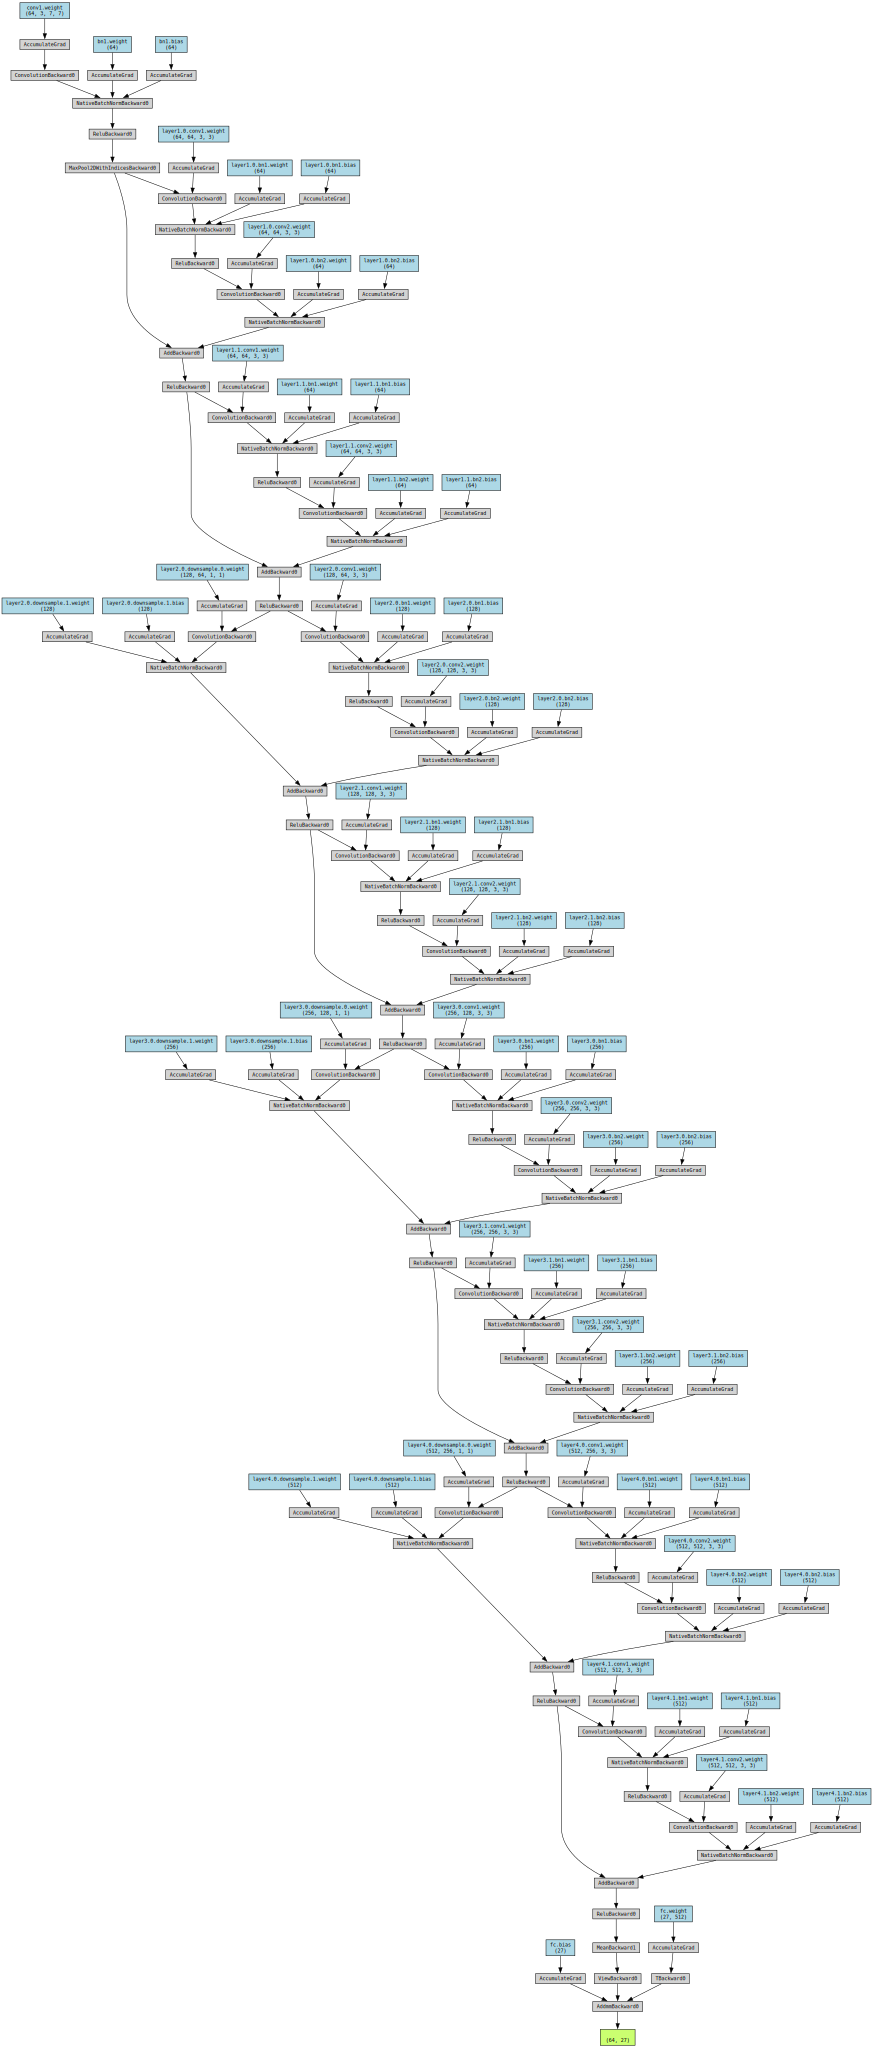

In [222]:
from torchviz import make_dot

make_dot(res_model(X_train), params=dict(res_model.named_parameters()))

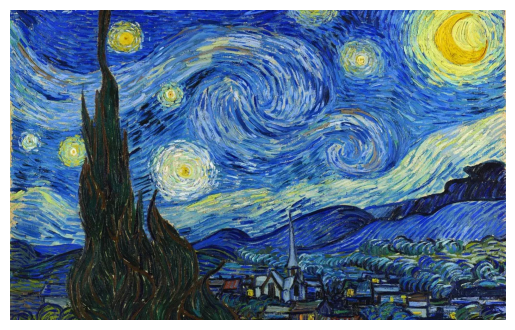

사용 모델 : <generator object Module.named_modules at 0x000001A31270A270>
[예상 스타일]
Fauvism===> 확률: 20.4717%

[기타 확률 표]
Abstract_Expressionism===> 확률: 4.22759%
Action_painting     ===> 확률: 1.67235%
Analytical_Cubism   ===> 확률: 12.6224%
Art_Nouveau         ===> 확률: 1.97675%
Baroque             ===> 확률: 0.47925%
Color_Field_Painting===> 확률: 0.481533%
Contemporary_Realism===> 확률: 0.827807%
Cubism              ===> 확률: 5.66565%
Early_Renaissance   ===> 확률: 0.173773%
Expressionism       ===> 확률: 1.12233%
Fauvism             ===> 확률: 20.4717%
High_Renaissance    ===> 확률: 7.63684%
Impressionism       ===> 확률: 0.520269%
Mannerism_Late_Renaissance===> 확률: 13.1415%
Minimalism          ===> 확률: 0.871294%
Naive_Art_Primitivism===> 확률: 0.89426%
New_Realism         ===> 확률: 0.213224%
Northern_Renaissance===> 확률: 1.5059%
Pointillism         ===> 확률: 4.15081%
Pop_Art             ===> 확률: 0.438932%
Post_Impressionism  ===> 확률: 1.70351%
Realism             ===> 확률: 12.67%
Rococo              ===> 확률: 0.48114

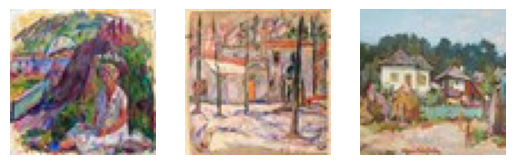

In [233]:
# 모델 예상함수 
def predict_style(img_name,model=res_model):
    imgtest = Image.open(img_name)
    #### ==> Resizing
    preprocessing = transforms.Compose(transforms=[
        transforms.Resize(size=(64,64)),
        transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406  ], std=[0.229, 0.224, 0.225])])
    input = preprocessing(imgtest).unsqueeze(0)
    output = model(input)
    # print(output)
    predict=F.softmax(output, dim=1)
    max_prob, predicted_class = torch.max(predict, dim=1)
    # print(predict)
    plt.imshow(imgtest)
    plt.axis('off')
    plt.show()
    
    
    styleList=styletxtDF['style'].tolist()
    for i in range(len(input)):
        print(f'사용 모델 : {model.named_modules()}')
        print(f'[예상 스타일]\n{styleList[predicted_class[i]]}===> 확률: {max_prob[i]*100:.6}%\n')
        # crossentropy 결과값의 크기 순서는 softmax의 기능이 
        print(f'[기타 확률 표]')
        for idx, styleL in enumerate(styleList):
            print(f'{styleL:20}===> 확률: {predict[0][idx]*100:.6}%')
    
    pathway = '../data/style_train/'+styleList[predicted_class[0]]+'/'
    example_list = os.listdir(pathway)[:3]
    for i in range(3): 
        plt.subplot(1, 3, i + 1)
        plt.axis('off')
        ex_img = Image.open(pathway + example_list[i])
        plt.imshow(ex_img)
        plt.axis('off')
    plt.show()
    #     plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    # for img_name in example_list:
    #     # print(pathway+img_name)
    #     ex_img = Image.open(pathway + img_name)
    #     plt.imshow(ex_img)
    #     plt.axis('off')
    #     plt.show()
    
predict_style('test1.jpg',res_model)

In [192]:
styleList=styletxtDF['style'].tolist()
styleList

['Abstract_Expressionism',
 'Action_painting',
 'Analytical_Cubism',
 'Art_Nouveau',
 'Baroque',
 'Color_Field_Painting',
 'Contemporary_Realism',
 'Cubism',
 'Early_Renaissance',
 'Expressionism',
 'Fauvism',
 'High_Renaissance',
 'Impressionism',
 'Mannerism_Late_Renaissance',
 'Minimalism',
 'Naive_Art_Primitivism',
 'New_Realism',
 'Northern_Renaissance',
 'Pointillism',
 'Pop_Art',
 'Post_Impressionism',
 'Realism',
 'Rococo',
 'Romanticism',
 'Symbolism',
 'Synthetic_Cubism',
 'Ukiyo_e']

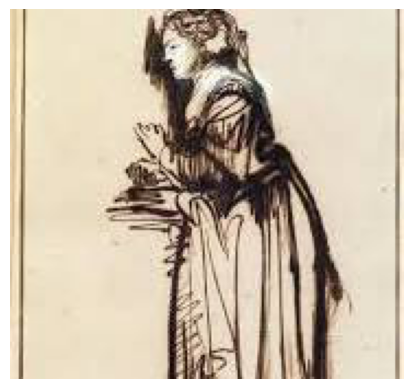

사용 모델 : <generator object Module.named_modules at 0x000001A31270AC10>
[예상 스타일]
Baroque===> 확률: 97.4946%

[기타 확률 표]
Abstract_Expressionism===> 확률: 0.030652%
Action_painting     ===> 확률: 2.74782e-10%
Analytical_Cubism   ===> 확률: 4.2347e-12%
Art_Nouveau         ===> 확률: 0.0399686%
Baroque             ===> 확률: 97.4946%
Color_Field_Painting===> 확률: 7.27703e-07%
Contemporary_Realism===> 확률: 9.61194e-07%
Cubism              ===> 확률: 0.186218%
Early_Renaissance   ===> 확률: 0.000399575%
Expressionism       ===> 확률: 0.000162481%
Fauvism             ===> 확률: 4.58226e-06%
High_Renaissance    ===> 확률: 7.00699e-05%
Impressionism       ===> 확률: 1.65984%
Mannerism_Late_Renaissance===> 확률: 4.11542e-05%
Minimalism          ===> 확률: 2.08548e-05%
Naive_Art_Primitivism===> 확률: 3.49362e-08%
New_Realism         ===> 확률: 0.000317037%
Northern_Renaissance===> 확률: 1.05931e-06%
Pointillism         ===> 확률: 7.90095e-09%
Pop_Art             ===> 확률: 8.56096e-06%
Post_Impressionism  ===> 확률: 0.0754582%
Realism      

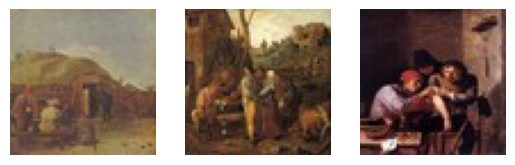

In [234]:
predict_style('test3.jpg',cnn_model)

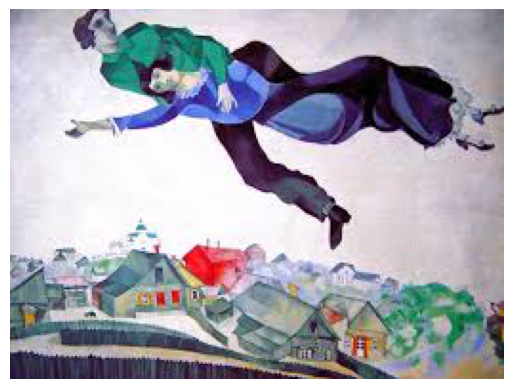

사용 모델 : <generator object Module.named_modules at 0x000001A31295E900>
[예상 스타일]
Symbolism===> 확률: 98.6196%

[기타 확률 표]
Abstract_Expressionism===> 확률: 0.0137871%
Action_painting     ===> 확률: 8.8501e-08%
Analytical_Cubism   ===> 확률: 5.63635e-08%
Art_Nouveau         ===> 확률: 0.139043%
Baroque             ===> 확률: 7.50392e-07%
Color_Field_Painting===> 확률: 3.98624e-06%
Contemporary_Realism===> 확률: 3.81615e-06%
Cubism              ===> 확률: 0.0814188%
Early_Renaissance   ===> 확률: 1.35136e-08%
Expressionism       ===> 확률: 0.00453477%
Fauvism             ===> 확률: 0.00332806%
High_Renaissance    ===> 확률: 2.45426e-06%
Impressionism       ===> 확률: 8.15804e-05%
Mannerism_Late_Renaissance===> 확률: 3.02305e-12%
Minimalism          ===> 확률: 1.55847e-06%
Naive_Art_Primitivism===> 확률: 0.0115514%
New_Realism         ===> 확률: 2.69497e-10%
Northern_Renaissance===> 확률: 3.84329e-07%
Pointillism         ===> 확률: 0.0080327%
Pop_Art             ===> 확률: 0.0014196%
Post_Impressionism  ===> 확률: 1.11571%
Realism     

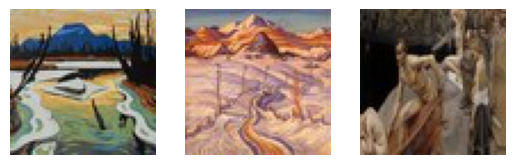

In [239]:
predict_style('test5.jpg',cnn_model)